In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# !pip install mlflow
# !pip install boto3

In [4]:
import pandas as pd
import numpy as np
import imblearn
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from imblearn.over_sampling import SMOTE,RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
import mlflow
import mlflow.sklearn
import os
import joblib

In [5]:
os.environ['MLFLOW_S3_ENDPOINT_URL'] = 'http://172.236.130.98:9000'
os.environ['AWS_ACCESS_KEY_ID'] = 'minioadmin'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'hfdH73jf8dff3E'
os.environ['MLFLOW_S3_IGNORE_TLS'] = 'true'

mlflow.set_tracking_uri('http://172.236.130.98:5000')
mlflow.set_experiment('lmb Experiment')

mlflow.sklearn.autolog()

In [6]:
data_path = "/content/drive/MyDrive/Datasets/Dataset_12.5.2025.csv"
dict_path = "/content/drive/MyDrive/Datasets/dict-words.txt"
sw_path = "/content/drive/MyDrive/Datasets/sw.txt"

In [7]:
data = pd.read_csv(data_path, encoding='utf-8')

In [8]:
data.drop(['Index'], axis=1)

,Sentence,Label
0,BRI နိုင်ငံများ အပြန်အလှန် ရင်းနှီးမြှုပ်နှံမှ...,Business
1,ရှမ်းပြည်နယ်မြောက်ပိုင်း မူဆယ်နယ်မြို့ ရှိ ဆင်...,Business
2,ယခုကဲ့သို့ သယ်ဆောင်ခွင့်ပြု ရာ တွင် လည်း ထောက်...,Business
3,ထိုသို့ မီးဖိုချောင်သုံးအသီးအနှံ အသားငါးများ က...,Business
4,မူဆယ်နယ်စပ်ကုန်သည်တဦး က နိုဝင်ဘာ ၂၉ ရက်မှာ စာရ...,Business
...,...,...
93491,Sir Paul said there's nothing bigger than bein...,Entertainment
93492,The ruling meant the movie was not eligible to...,Entertainment
93493,Rapper Snoop Dogg sued for rape us rapper Snoo...,Entertainment
93494,The woman said she was assaulted after a recor...,Entertainment


In [9]:
# preprocessor.py
import re
from nltk.stem import SnowballStemmer
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stemmer = SnowballStemmer("english")
english_stopwords = set(stopwords.words('english'))

def stem_tokens(tokens):
    return [stemmer.stem(token) for token in tokens]

class MyanmarTextPreprocessor():
    def __init__(self, dict_path: str, stop_path: str):
        self.dictionary = self.load_dictionary(dict_path)
        self.stopwords = self.load_stopwords(stop_path)

    def load_dictionary(self, dict_path):
        dictionary = set()
        with open(dict_path, 'r', encoding='utf-8') as f:
            for line in f:
                word = line.strip()
                if word:
                    dictionary.add(word)
        return dictionary

    def load_stopwords(self, stopword_path):
        stopwords = set()
        with open(stopword_path, 'r', encoding='utf-8') as f:
            for line in f:
                word = line.strip()
                if word:
                    stopwords.add(word)
        return stopwords

    def merge_with_dictionary(self, syllables):
        merged_tokens = []
        i = 0
        while i < len(syllables):
            matched = False
            for j in range(len(syllables), i, -1):
                combined = ''.join(syllables[i:j])
                if combined in self.dictionary:
                    merged_tokens.append(combined)
                    i = j
                    matched = True
                    break
            if not matched:
                merged_tokens.append(syllables[i])
                i += 1
        return merged_tokens

    def preprocessing(self, text: str):
        text = re.sub(r"(([A-Za-z0-9]+)|[က-အ|ဥ|ဦ](င်္|[က-အ][ှ]*[့း]*[်]|္[က-အ]|[ါ-ှႏꩻ][ꩻ]*){0,}|.)", r"\1 ", text)
        text = ' '.join(stem_tokens(text.split()))
        text = text.strip().split()
        merged_tokens = self.merge_with_dictionary(text)
        filtered_tokens = [token for token in merged_tokens if token not in self.stopwords]
        filtered_tokens= [token for token in filtered_tokens if token not in english_stopwords]
        return ' '.join(filtered_tokens)


map_label = {
    'Social': 0,
    'Entertainment': 1,
    'Product&Service': 2,
    'Business': 3,
    'Sports': 4,
    'Science&Technology': 5,
    'Education': 6,
    'Culture&History': 7,
    'Health': 8,
    'Environmental': 9,
    'Political': 10,
    'Gambling': 11,
    'Adult Content': 12,
}



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
preprocessor = MyanmarTextPreprocessor(dict_path, sw_path)
data['encoded_Sentence'] = data['Sentence'].apply(preprocessor.preprocessing)


In [11]:
data['encoded_Label'] = data['Label'].map(map_label)
count = data['Label'].value_counts()
print(count)

Label
Product&Service       9962
Political             9835
Business              9166
Health                8978
Sports                8217
Culture&History       7976
Education             7395
Social                7196
Entertainment         6972
Science&Technology    5187
Environmental         5098
Gambling              4416
Adult Content         3098
Name: count, dtype: int64


In [12]:
data.head(3)

,Index,Sentence,Label,encoded_Sentence,encoded_Label
0,0,BRI နိုင်ငံများ အပြန်အလှန် ရင်းနှီးမြှုပ်နှံမှ...,Business,bri နိုင်ငံ အပြန်အလှန် ရင်းနှီးမြှုပ်နှံမှု ဆက...,3
1,1,ရှမ်းပြည်နယ်မြောက်ပိုင်း မူဆယ်နယ်မြို့ ရှိ ဆင်...,Business,ရှမ်းပြည်နယ် မြောက် မူ ဆင် ဖြူ ဂိတ် စက်သုံးဆီ ...,3
2,2,ယခုကဲ့သို့ သယ်ဆောင်ခွင့်ပြု ရာ တွင် လည်း ထောက်...,Business,ယခု ကဲ့သို့ သယ်ဆောင် ခွင့်ပြု ရာတွင် ထောက်ခံ မ...,3


In [13]:
# to avoid data leakage
data = data.drop_duplicates(subset='encoded_Sentence')
X = data['encoded_Sentence']
y = data['encoded_Label']

X_train_text, X_test_text, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42, stratify=y)
X_train_text = X_train_text.apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
X_test_text = X_test_text.apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

vectorizer = TfidfVectorizer(max_features=10000,max_df=0.85,min_df=2,ngram_range=(1, 2))
X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)
joblib.dump(vectorizer, 'vectorizer.pkl')
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [14]:
train_set = set(X_train_text)
test_set = set(X_test_text)
overlap = train_set.intersection(test_set)

print(f"Overlap: {len(overlap)}")  # Should be zero or very small

Overlap: 0


In [15]:
len(train_set)

69747

In [16]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

2025/05/15 07:56:50 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2504f6e5c1644aa28ea9129fb4159e85', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/05/15 07:56:53 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2025/05/15 07:56:53 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2025/05/15 07:56:53 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/05/15 07:57:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signatu

🏃 View run orderly-ox-277 at: http://172.236.130.98:5000/#/experiments/6/runs/2504f6e5c1644aa28ea9129fb4159e85
🧪 View experiment at: http://172.236.130.98:5000/#/experiments/6


2025/05/15 07:57:11 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '574c7efea09b490baea2ba15d68f58ef', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/05/15 07:57:12 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2025/05/15 07:57:12 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2025/05/15 07:57:12 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/05/15 07:57:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signatu

🏃 View run amusing-tern-558 at: http://172.236.130.98:5000/#/experiments/6/runs/574c7efea09b490baea2ba15d68f58ef
🧪 View experiment at: http://172.236.130.98:5000/#/experiments/6


2025/05/15 07:57:26 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '9dd4419476634ac8b73a240af8e3311a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/05/15 07:57:28 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2025/05/15 07:57:28 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2025/05/15 07:57:28 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/05/15 07:57:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signatu

🏃 View run sedate-sloth-645 at: http://172.236.130.98:5000/#/experiments/6/runs/9dd4419476634ac8b73a240af8e3311a
🧪 View experiment at: http://172.236.130.98:5000/#/experiments/6


2025/05/15 07:57:41 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7613043a4e3d4448b3ab56bb73db82aa', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/05/15 07:57:42 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2025/05/15 07:57:42 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2025/05/15 07:57:42 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/05/15 07:57:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signatu

🏃 View run gentle-doe-225 at: http://172.236.130.98:5000/#/experiments/6/runs/7613043a4e3d4448b3ab56bb73db82aa
🧪 View experiment at: http://172.236.130.98:5000/#/experiments/6


2025/05/15 07:57:54 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ca4f5f1da5924d4bb6f9b9595144b27e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/05/15 07:57:55 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2025/05/15 07:57:55 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2025/05/15 07:57:55 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/05/15 07:58:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signatu

🏃 View run salty-bird-420 at: http://172.236.130.98:5000/#/experiments/6/runs/ca4f5f1da5924d4bb6f9b9595144b27e
🧪 View experiment at: http://172.236.130.98:5000/#/experiments/6


2025/05/15 07:58:06 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '420aa49c338746eebbec19ca0d8fdd6c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/05/15 07:58:08 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2025/05/15 07:58:08 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2025/05/15 07:58:08 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/05/15 07:58:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signatu

🏃 View run handsome-pug-609 at: http://172.236.130.98:5000/#/experiments/6/runs/420aa49c338746eebbec19ca0d8fdd6c
🧪 View experiment at: http://172.236.130.98:5000/#/experiments/6


2025/05/15 07:58:20 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '35852ff5e7bf4d8cb298fa440c209adf', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/05/15 07:58:21 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2025/05/15 07:58:21 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2025/05/15 07:58:21 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/05/15 07:58:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signatu

🏃 View run gentle-goose-533 at: http://172.236.130.98:5000/#/experiments/6/runs/35852ff5e7bf4d8cb298fa440c209adf
🧪 View experiment at: http://172.236.130.98:5000/#/experiments/6


2025/05/15 07:58:34 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0e4b61fcfb92471189bd4847ff28b702', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/05/15 07:58:36 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2025/05/15 07:58:36 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2025/05/15 07:58:36 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/05/15 07:58:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signatu

🏃 View run angry-gnu-7 at: http://172.236.130.98:5000/#/experiments/6/runs/0e4b61fcfb92471189bd4847ff28b702
🧪 View experiment at: http://172.236.130.98:5000/#/experiments/6


2025/05/15 07:58:49 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '01b3575bb0b549b2bc041fdc7d6c83df', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/05/15 07:58:50 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2025/05/15 07:58:50 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2025/05/15 07:58:50 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/05/15 07:58:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signatu

🏃 View run bedecked-calf-11 at: http://172.236.130.98:5000/#/experiments/6/runs/01b3575bb0b549b2bc041fdc7d6c83df
🧪 View experiment at: http://172.236.130.98:5000/#/experiments/6


2025/05/15 07:59:02 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f9c1ef8aa5cb4f27ba4b9c860ee6c267', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/05/15 07:59:04 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2025/05/15 07:59:04 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2025/05/15 07:59:04 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/05/15 07:59:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signatu

🏃 View run youthful-shrike-831 at: http://172.236.130.98:5000/#/experiments/6/runs/f9c1ef8aa5cb4f27ba4b9c860ee6c267
🧪 View experiment at: http://172.236.130.98:5000/#/experiments/6


2025/05/15 07:59:18 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '375f0b10110b41658c59cb77539d4c11', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/05/15 07:59:19 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2025/05/15 07:59:19 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2025/05/15 07:59:19 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/05/15 07:59:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signatu

🏃 View run puzzled-pug-170 at: http://172.236.130.98:5000/#/experiments/6/runs/375f0b10110b41658c59cb77539d4c11
🧪 View experiment at: http://172.236.130.98:5000/#/experiments/6


2025/05/15 07:59:30 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6d8b3a4b431240c59a0b5e4a45078502', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/05/15 07:59:31 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2025/05/15 07:59:31 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2025/05/15 07:59:31 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/05/15 07:59:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signatu

🏃 View run clean-ant-917 at: http://172.236.130.98:5000/#/experiments/6/runs/6d8b3a4b431240c59a0b5e4a45078502
🧪 View experiment at: http://172.236.130.98:5000/#/experiments/6


In [17]:
with mlflow.start_run():
    clf = LinearSVC(class_weight='balanced', verbose=1, max_iter=10000)
    clf.fit(X_res, y_res)

    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    mlflow.log_param("model_type", "LinearSVC")
    mlflow.log_param("class_weight", "balanced")

    mlflow.log_metric("accuracy", acc)

    report = classification_report(y_test, y_pred, output_dict=True)
    for label, scores in report.items():
        if isinstance(scores, dict):
            for metric, value in scores.items():
                mlflow.log_metric(f"{label}_{metric}", value)

    mlflow.sklearn.log_model(clf, "model")

    print("Run logged to MLflow.")


[LibLinear]

2025/05/15 08:01:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run logged to MLflow.
🏃 View run adaptable-loon-952 at: http://172.236.130.98:5000/#/experiments/6/runs/06e8283191674c6785d4b015910e1b8f
🧪 View experiment at: http://172.236.130.98:5000/#/experiments/6


In [18]:
# import joblib

# joblib.dump(clf, f'svm_{acc}.pkl')

In [19]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# sns.countplot(x=y)
# plt.xticks(rotation=45)
# plt.title("Class distribution")
# plt.show()


In [20]:
# from lightgbm import LGBMClassifier

# with mlflow.start_run():
#     clf = LGBMClassifier(class_weight='balanced', n_jobs=-1)
#     clf.fit(X_res, y_res)

#     y_pred = clf.predict(X_test)
#     acc = accuracy_score(y_test, y_pred)

#     mlflow.log_param("model_type", "LGBMClassifier")
#     mlflow.log_param("class_weight", "balanced")

#     mlflow.log_metric("accuracy", acc)

#     report = classification_report(y_test, y_pred, output_dict=True)
#     for label, scores in report.items():
#         if isinstance(scores, dict):
#             for metric, value in scores.items():
#                 mlflow.log_metric(f"{label}_{metric}", value)

#     mlflow.sklearn.log_model(clf, "model")

#     print("Run logged to MLflow.")


In [21]:
# from sklearn.metrics import classification_report
# print(classification_report(y_test, y_pred, digits=4))


In [22]:
# joblib.dump(clf, f'LGBM_{acc}.pkl')

In [23]:
# from sklearn.neighbors import KNeighborsClassifier

# knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

# with mlflow.start_run():
#     knn.fit(X_res, y_res)

#     y_pred = clf.predict(X_test)
#     acc = accuracy_score(y_test, y_pred)

#     mlflow.log_param("model_type", "KnnClassifier")
#     mlflow.log_param("class_weight", "balanced")

#     mlflow.log_metric("accuracy", acc)

#     report = classification_report(y_test, y_pred, output_dict=True)
#     for label, scores in report.items():
#         if isinstance(scores, dict):
#             for metric, value in scores.items():
#                 mlflow.log_metric(f"{label}_{metric}", value)

#     mlflow.sklearn.log_model(clf, "model")

#     print("Run logged to MLflow.")


In [24]:
# joblib.dump(clf, f'knn_{acc}.pkl')

In [25]:
# from sklearn.ensemble import RandomForestClassifier

# with mlflow.start_run():
#     clf = RandomForestClassifier(n_estimators=100,criterion='gini',n_jobs=-1,class_weight='balanced')
#     clf.fit(X_res, y_res)

#     y_pred = clf.predict(X_test)
#     acc = accuracy_score(y_test, y_pred)

#     mlflow.log_param("model_type", "RFClassifier")

#     mlflow.log_metric("accuracy", acc)

#     report = classification_report(y_test, y_pred, output_dict=True)
#     for label, scores in report.items():
#         if isinstance(scores, dict):
#             for metric, value in scores.items():
#                 mlflow.log_metric(f"{label}_{metric}", value)

#     mlflow.sklearn.log_model(clf, "model")

#     print("Run logged to MLflow.")


In [26]:
# joblib.dump(clf, f'RFCzip_{acc}.pkl',compress=('zlib',3))

In [27]:
# rf_clf = joblib.load('/content/drive/MyDrive/Datasets/RFCzip_0.6953604404427367.pkl')
# knn_clf = joblib.load('/content/drive/MyDrive/Datasets/knn_0.7507025291047772.pkl')
# svm_clf = joblib.load('/content/drive/MyDrive/Datasets/svm_0.7571830016631301.pkl')
# lgtm = joblib.load('/content/drive/MyDrive/Datasets/LGBM_0.7507025291047772.pkl')
# vectorizers = joblib.load('/content/drive/MyDrive/Datasets/vectorizer.pkl')

# models = {
#     "Random Forest": rf_clf,
#     "KNN": knn_clf,
#     "LightGBM": lgtm,
#     "SVM":svm_clf
# }


In [28]:
# test_sentences = "ဗုံးပေါက်ကွဲတဲ့ပုံစံအရ ရှောင်လို့တိမ်းလို့ တော်တော် မလွယ်လောက်ဘူး။ အစအနမှန်ထားတာတွေ ပွစာကြဲပြီးတော့မှ ဟိုးဘက်ခပ်လှမ်းလှမ်းမှာရှိတဲ့ ထန်းပင်တွေပါ ပြတ်ထွက်တာဆိုတော့ ကလေးတွေက စာသင်ရင်း အုံးကနဲကြားလိုက်တယ်၊ ဗြုန်းကနဲ သူတို့ အသက်ထွက်သွားတဲ့ အနေအထားရှင့်။"
# preprocced_sentence = preprocessor.preprocessing(test_sentences)
# vec_sent = vectorizers.transform([preprocced_sentence])

# for name, model in models.items():
#     pred = model.predict(vec_sent)[0]
#     print(pred)
#     label = [k for k, v in map_label.items() if v == pred][0]
#     print(f"{name} Prediction: {label}")

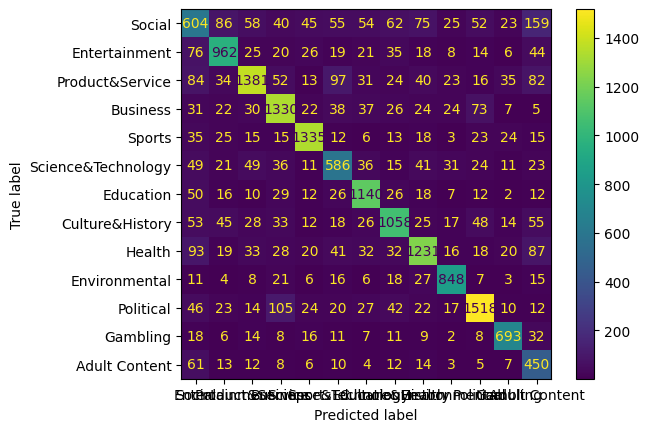

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# y_pred = model.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=map_label.keys())
